In [19]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup

#### Pull Historical S&P 500 Index data for 2023

In [20]:
dat = yf.Ticker('^GSPC')
df = dat.history(start="2023-01-01", end="2023-12-31")

In [21]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,0.0,0.0
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,0.0,0.0
2023-01-05 00:00:00-05:00,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,0.0,0.0
2023-01-06 00:00:00-05:00,3823.370117,3906.189941,3809.560059,3895.080078,3923560000,0.0,0.0
2023-01-09 00:00:00-05:00,3910.820068,3950.570068,3890.419922,3892.090088,4311770000,0.0,0.0


In [22]:
df.dtypes, df.shape

(Open            float64
 High            float64
 Low             float64
 Close           float64
 Volume            int64
 Dividends       float64
 Stock Splits    float64
 dtype: object,
 (250, 7))

In [23]:
df['Dividends'].unique(), df['Stock Splits'].unique()

(array([0.]), array([0.]))

In [24]:
df = df[['Close', 'Volume']]

In [25]:
df.head()

,Close,Volume
Date,,
2023-01-03 00:00:00-05:00,3824.139893,3959140000
2023-01-04 00:00:00-05:00,3852.969971,4414080000
2023-01-05 00:00:00-05:00,3808.100098,3893450000
2023-01-06 00:00:00-05:00,3895.080078,3923560000
2023-01-09 00:00:00-05:00,3892.090088,4311770000


#### Plot the daily Close and Volume

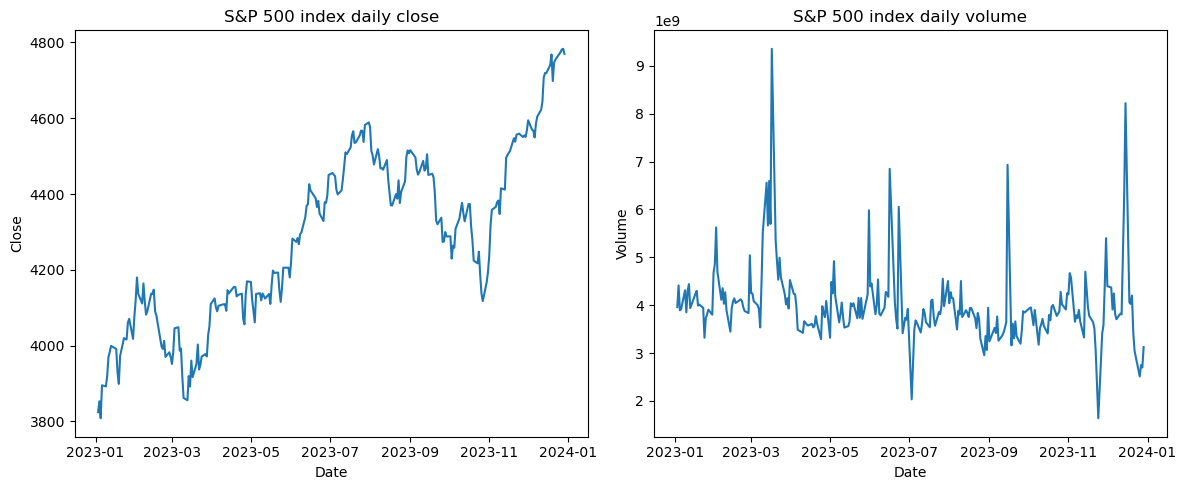

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
sns.lineplot(data=df['Close'], ax=axes[0])
axes[0].set_title('S&P 500 index daily close')
sns.lineplot(data=df['Volume'], ax=axes[1])
axes[1].set_title('S&P 500 index daily volume')
plt.tight_layout()
plt.show()

In [27]:
df['Return'] = df['Close'].apply(lambda x: (x - df.iloc[0]['Close']) / x * 100)

#### Plot the cumulative daily return

<Axes: xlabel='Date', ylabel='Return'>

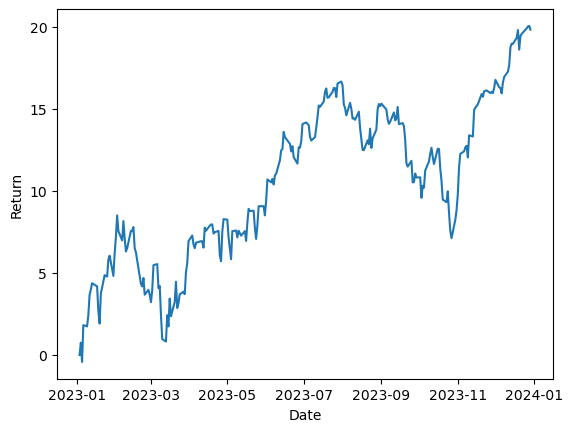

In [28]:
sns.lineplot(data=df['Return'])

In [29]:
print(f'{df.iloc[-1]['Return']} % return')

19.826496333358314 % return


##### For the year 2023, the S&P returned an approx of 19.8%.

#### Web Scrape the list of S&P 500 companies for 2023 (we assume that this list of companies is static)

In [30]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies&oldid=1192789360"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find("table", {"class": "wikitable sortable"})
headers = [header.text.strip() for header in table.find("tr").find_all("th")]
rows = table.find_all("tr")[1:]

data = []
for row in rows:
    cols = row.find_all("td")
    cols = [col.text.strip() for col in cols]
    if cols:
        data.append(cols)
sp500_df = pd.DataFrame(data, columns=headers)

In [31]:
sp500_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


In [32]:
sp500_df.shape

(503, 8)

In [33]:
sp500_df = sp500_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]

In [34]:
tickers = sp500_df['Symbol'].to_list()

#### Pull the daily prices for each of the companies in the S&P 500 index

In [35]:
df = pd.DataFrame({})
for ticker in tickers:
    dat = yf.Ticker(ticker)
    dt = dat.history(start="2023-01-01", end="2023-12-31")
    if (len(dt) < 2):
        continue
    ret = (dt.iloc[-1]['Close'] - dt.iloc[0]['Close']) / dt.iloc[0]['Close'] * 100
    df_temp = pd.DataFrame({
        'Symbol':ticker, 
        'Return': ret, 
        'Volume_2023_Start': dt.iloc[0]['Volume'],
        'Price_2023_Start': dt.iloc[0]['Close']
        }, index=[0])
    df = pd.concat([df, df_temp], ignore_index=True)


$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2023-01-01 -> 2023-12-31)
$CTLT: possibly delisted; no timezone found
$CDAY: possibly delisted; no timezone found
$FLT: possibly delisted; no timezone found
$PEAK: possibly delisted; no timezone found
$MRO: possibly delisted; no timezone found
$PXD: possibly delisted; no timezone found
$WRK: possibly delisted; no timezone found


In [36]:
df.head()

,Symbol,Return,Volume_2023_Start,Price_2023_Start
0,MMM,-5.340932,3124909.0,92.868958
1,AOS,42.495103,1366200.0,56.647530
2,ABT,2.456596,4171900.0,104.779053
3,ABBV,-0.707935,4937500.0,149.164124
4,ACN,31.904533,2250100.0,261.824371


In [37]:
sp500_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


In [38]:
df_final = pd.merge(df, sp500_df, 'inner', 'Symbol')

In [39]:
df_final.head()

,Symbol,Return,Volume_2023_Start,Price_2023_Start,Security,GICS Sector,GICS Sub-Industry
0,MMM,-5.340932,3124909.0,92.868958,3M,Industrials,Industrial Conglomerates
1,AOS,42.495103,1366200.0,56.647530,A. O. Smith,Industrials,Building Products
2,ABT,2.456596,4171900.0,104.779053,Abbott,Health Care,Health Care Equipment
3,ABBV,-0.707935,4937500.0,149.164124,AbbVie,Health Care,Biotechnology
4,ACN,31.904533,2250100.0,261.824371,Accenture,Information Technology,IT Consulting & Other Services


In [40]:
df_final.shape

(494, 7)

#### We group the companies by sector and calculate the sector-wise mean return

In [41]:
sector_returns = df_final.groupby('GICS Sector')['Return'].mean()

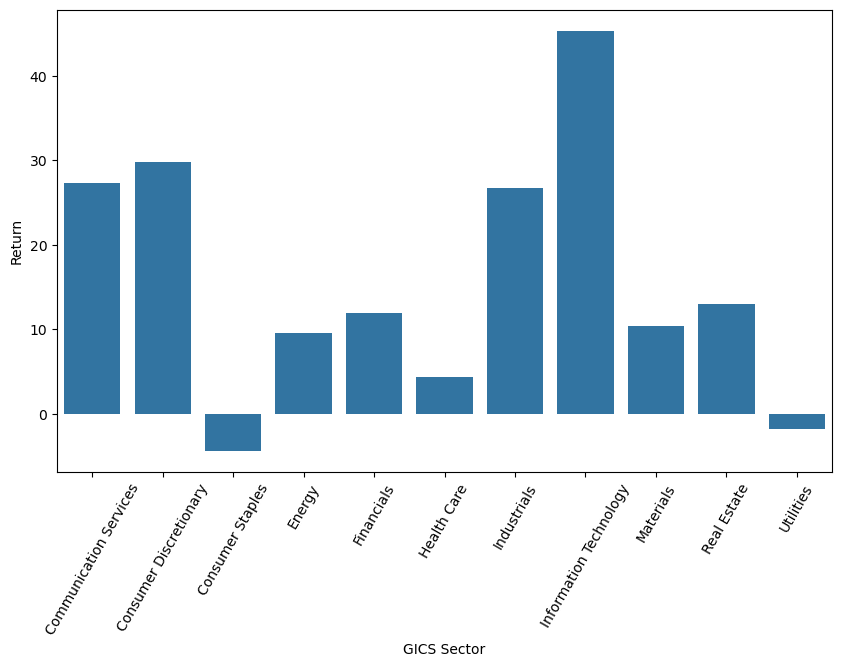

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(sector_returns)
plt.xticks(rotation=60)
plt.show()

#### We group the companies by market capitalization

In [43]:
df_final['Market_Cap'] = df['Price_2023_Start'] * df['Volume_2023_Start'] / 1_000_000_000
df_final.head()

,Symbol,Return,Volume_2023_Start,Price_2023_Start,Security,GICS Sector,GICS Sub-Industry,Market_Cap
0,MMM,-5.340932,3124909.0,92.868958,3M,Industrials,Industrial Conglomerates,0.290207
1,AOS,42.495103,1366200.0,56.647530,A. O. Smith,Industrials,Building Products,0.077392
2,ABT,2.456596,4171900.0,104.779053,Abbott,Health Care,Health Care Equipment,0.437128
3,ABBV,-0.707935,4937500.0,149.164124,AbbVie,Health Care,Biotechnology,0.736498
4,ACN,31.904533,2250100.0,261.824371,Accenture,Information Technology,IT Consulting & Other Services,0.589131


In [44]:
def get_market_cap_category(market_cap):
    if market_cap > 1:
        return "large cap"
    elif market_cap > 0.5:
        return "mid cap"
    else:
        return "small cap"
df_final['Market_Cap_Category'] = df_final.apply(lambda x: get_market_cap_category(x['Market_Cap']), axis=1)

In [45]:
df_final.head()

,Symbol,Return,Volume_2023_Start,Price_2023_Start,Security,GICS Sector,GICS Sub-Industry,Market_Cap,Market_Cap_Category
0,MMM,-5.340932,3124909.0,92.868958,3M,Industrials,Industrial Conglomerates,0.290207,small cap
1,AOS,42.495103,1366200.0,56.647530,A. O. Smith,Industrials,Building Products,0.077392,small cap
2,ABT,2.456596,4171900.0,104.779053,Abbott,Health Care,Health Care Equipment,0.437128,small cap
3,ABBV,-0.707935,4937500.0,149.164124,AbbVie,Health Care,Biotechnology,0.736498,mid cap
4,ACN,31.904533,2250100.0,261.824371,Accenture,Information Technology,IT Consulting & Other Services,0.589131,mid cap


In [46]:
size_returns = df_final.groupby('Market_Cap_Category')['Return'].mean().reset_index()
size_returns

,Market_Cap_Category,Return
0,large cap,52.529254
1,mid cap,21.207606
2,small cap,15.522519


<Axes: xlabel='Market_Cap_Category', ylabel='Return'>

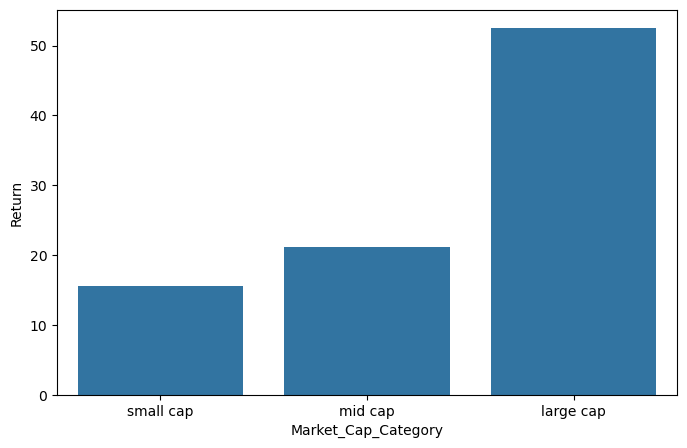

In [47]:
plt.figure(figsize=(8, 5))
sns.barplot(data=size_returns, x='Market_Cap_Category', y='Return', order=["small cap", "mid cap", "large cap"])

In [48]:
df_final['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)